# Benchmarking binary classifiers


### Intro and objectives


### In this lab you will learn:
1. How to use performance metrics to benchmark different binary classifiers

## What I hope you'll get out of this lab
* Worked Examples
* How to interpret the results obtained

In [1]:

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import matplotlib.patches as patches  # extra code – for the curved arrow

### In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of machine learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns machine learning tackles this dataset sooner or later.

#### Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset from OpenML.org

In [2]:


# Load data

mnist = fetch_openml('mnist_784', as_frame=False)

The sklearn.datasets package contains mostly three types of
functions: fetch_* functions such as fetch_openml() to download
real-life datasets, load_* functions to load small toy datasets bundled with
Scikit-Learn (so they don’t need to be downloaded over the internet), and
make_* functions to generate fake datasets, useful for tests. Generated
datasets are usually returned as an (X, y) tuple containing the input data
1
and the targets, both as NumPy arrays

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

#### There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset (Figure 3-1). All we need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function. We use cmap="binary" to get a grayscale color map where 0 is white and 255 is black:

In [6]:
def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

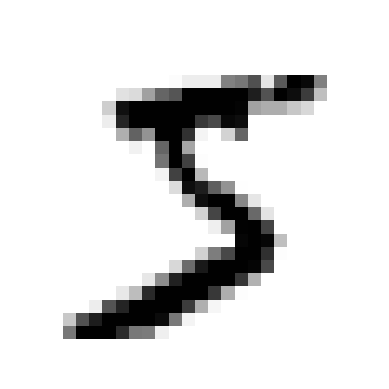

In [7]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
# Let's check if the image corresponds with the number 5
y[0]

'5'

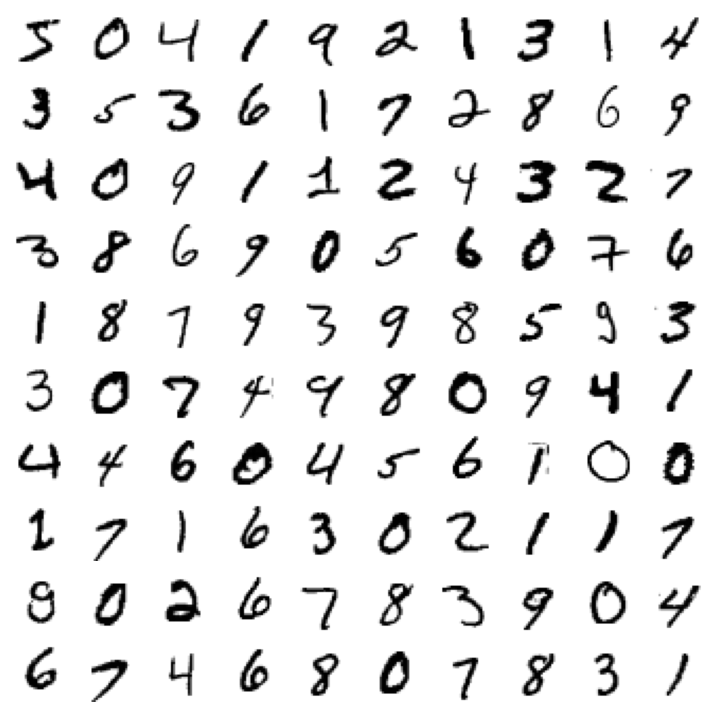

In [9]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)



## 1. Let's split the data into train and test sets

#### The MNIST dataset returned by fetch_openml() is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)



In [10]:

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 2. Let's train some binary classifiers

### Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5.

### We will train several binary classifiers and measure their performance

In [11]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

### 2.1 SDGClassifier

In [12]:


sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#### Confusion Matrix

In [14]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

<Axes: >

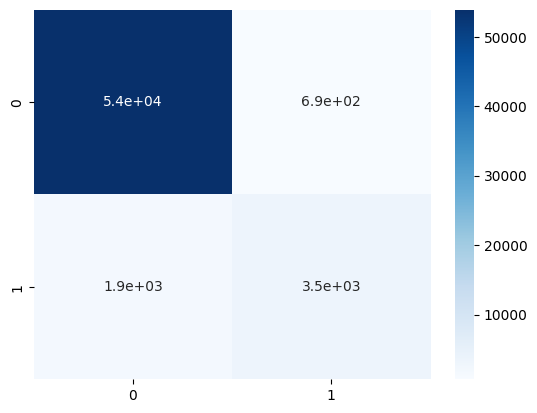

In [15]:
import seaborn as sns
sns.heatmap(cm, annot=True,cmap='Blues')

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

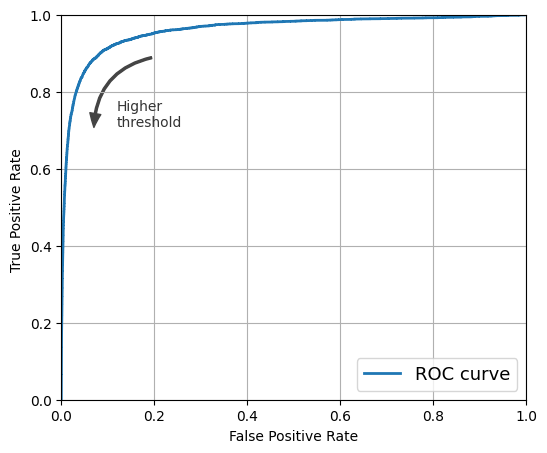

In [18]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")


# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate ')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)


plt.show()

In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### 2.2 RandomForest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)


In [21]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [22]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [23]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive

#### Confusion Matrix

In [24]:
cm = confusion_matrix(y_train_5, y_train_pred_forest)
cm


array([[54530,    49],
       [  691,  4730]])

<Axes: >

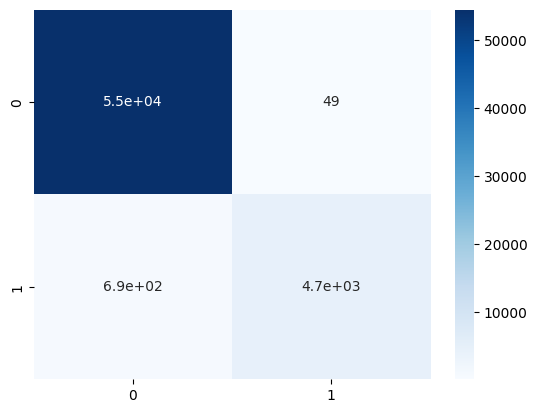

In [25]:
sns.heatmap(cm, annot=True,cmap='Blues')

### Based on the confusion matrices, the Random Forest based classifier seems to outperform its SDG counterpart

In [26]:
y_scores_forest = y_probas_forest[:, 1]


In [27]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

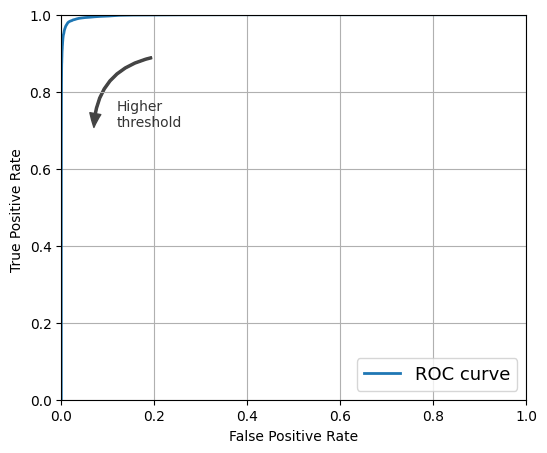

In [28]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="ROC curve")


# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate ')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)


plt.show()

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Based on the previous figure and the ROC AUC score we conclude that the random forest based classifier is a better alternative.